# Writing Production Code

### Loading Libraries

In [1]:
# Numerical Computing
import numpy as np

# Data Management
import pandas as pd

# Data Visualization
import seaborn as sns
import matplotlib.dates as md
import matplotlib.pyplot as plt
import matplotlib.ticker as tick

# Date & Time
import datetime

# Random
import random

In [2]:
ORIGINAL_DATA = np.array((199.9, 207.2, 185.3, 312.7, 277.3, 373.5, 456.2, 
                   121.9, 155.3, 167.4, 222.1, 139.2, 157.8, 212.1, 
                   241.8, 277.2, 145.6, 192.2, 203.4, 166.5, 177.3, 193.1, 134.9, 199.9, 217.4))

BOUNDARY_DATA = np.array((155.1, 173.2, 183.9, 217.3, 224.9))

In [3]:
def na_replacements(data, mode):
    series = data.copy()
    valid_check = ~np.isnan(series)
    valid_indeces = valid_check.ravel().nonzero()[0]
    invalid_indeces = np.isnan(series).ravel().nonzero()[0]
    valid_values = series[valid_check]
    
    if mode == 'intr':
        series[np.isnan(series)] = np.interp(invalid_indeces, valid_indeces, valid_values)
    elif mode == 'zero':
        series[np.isnan(series)] = 0.0
    else:
        raise ValueError("Improper mode selected. Must be either 'intr' or 'zero'")
    return series

In [4]:
def generate_data(feature_array, boundary_array, replacements='zero', start_date="2021-04-07"):
    adjusted_features = [x * 0.82 for x in feature_array.copy()]
    np.random.shuffle(adjusted_features)
    nulls = np.array([np.nan] * feature_array.size)
    orig_features = np.append(np.append(feature_array, boundary_array), nulls)
    new_features = np.append(nulls, np.append(boundary_array, adjusted_features))
    dates = np.arange(np.datetime64(start_date), np.timedelta64(orig_features.size, 'D'))
    df = pd.DataFrame(np.array((dates, 
                                na_replacements(orig_features, replacements), 
                                na_replacements(new_features, replacements))).T,
                      columns=["date", "original_feature", "new_feature"]
                     )
    df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")
    df.set_index('date', inplace=True)
    df.index = pd.DatetimeIndex(df.index.values, freq=df.index.inferred_freq)
    
    return df

In [11]:
def plot_data(data, cutoff_size, boundary_size, image_name="whoops"):
    with plt.style.context(style='seaborn-v0_8'):
        fig, axes = plt.subplots(2, 1, figsize=(9, 9))
        plt.subplots_adjust(hspace=0.4)
        ax0 = data['original_feature'].plot(ax=axes[0], ls='-', c='royalblue', lw=3, 
                                        label='Bags of dog food sold per day')
        ax1 = data['new_feature'].plot(ax=axes[1], ls='-', c='forestgreen', lw=3, 
                                        label='Bags of dog food sold per day adjusted')
        axes[0].set_title("Historical data for dog food sales", fontsize=10)
        axes[1].set_title("New adjusted dog food sales", fontsize=10)
        axes[0].legend(loc='upper right')
        axes[1].legend(loc='upper left')
        axes[0].vlines(data.index[cutoff_size], 0, ORIGINAL_DATA.max(), color='tomato', lw=4)
        axes[0].vlines(data.index[cutoff_size + boundary_size -1], 0, ORIGINAL_DATA.max(), color='r', lw=4)
        axes[1].vlines(data.index[cutoff_size], 0, ORIGINAL_DATA.max(), color='tomato', lw=4)
        axes[1].vlines(data.index[cutoff_size + boundary_size -1], 0, ORIGINAL_DATA.max(), color='r', lw=4)
        axes[0].set_xlabel('Date', fontsize=10)
        axes[0].set_ylabel('Sales (in thousands)', fontsize=10)
        axes[1].set_xlabel('Date', fontsize=10)
        axes[1].set_ylabel('Sales (in thousands)', fontsize=10)
        plt.tight_layout()
        plt.savefig("{}.svg".format(image_name), format='svg')
        plt.show()

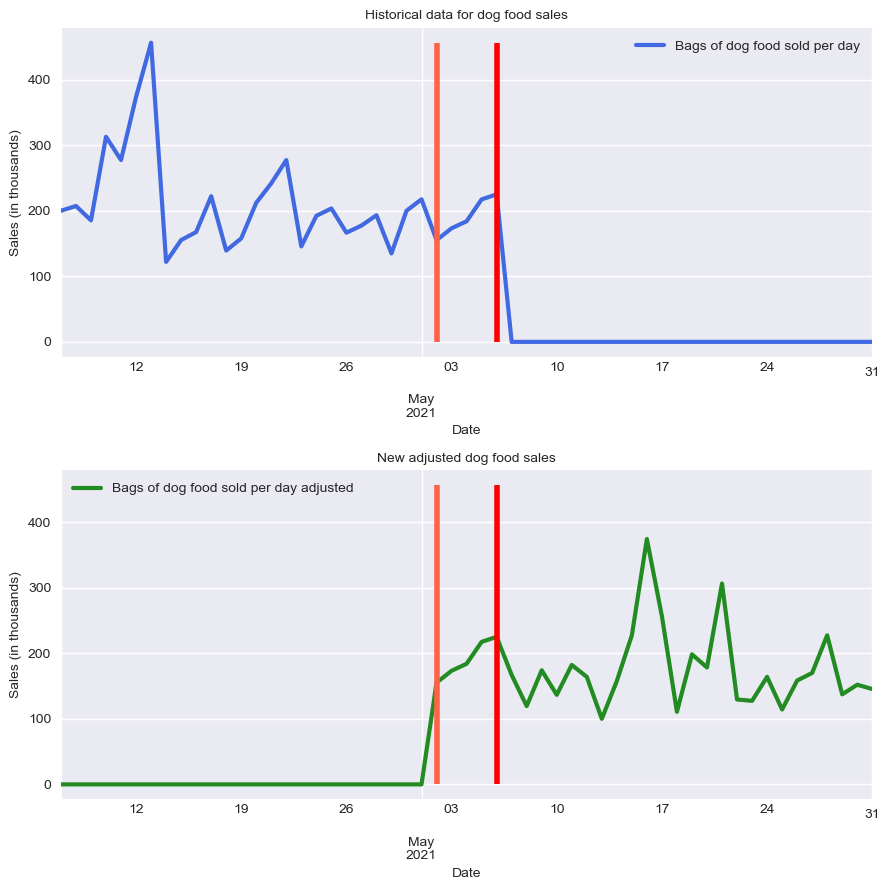

In [12]:
whoops = generate_data(ORIGINAL_DATA, BOUNDARY_DATA)
plot_data(whoops, ORIGINAL_DATA.size, BOUNDARY_DATA.size)

#### A Very Simple Feature Monitoring Script